
# Hand gesture recognition model customization guide



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The MediaPipe Model Maker package is a low-code solution for customizing on-device machine learning (ML) Models.

This notebook shows the end-to-end process of customizing a gesture recognizer model for recognizing Arabic letters sign language [Arsl](https://www.kaggle.com/datasets/59761a7132888de252ded8443ced1c7fb21ad28be5598f1f6ca43c663c32b40b)

## Prerequisites

Install the MediaPipe Model Maker package.

In [2]:
!pip install --upgrade pip
!pip install mediapipe-model-maker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 106.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

Import the required libraries.

In [3]:
from google.colab import files
import os
import tensorflow as tf
assert tf.__version__.startswith('2')

from mediapipe_model_maker import gesture_recognizer

import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


### Get the dataset

The dataset for gesture recognition in model maker requires the following format: `<dataset_path>/<label_name>/<img_name>.*`. In addition, one of the label names (`label_names`) must be `none`. The `none` label represents any gesture that isn't classified as one of the other gestures.


In [4]:
# dataset path to ArSL dataset in drive
dataset_path = "/content/drive/MyDrive/project1/RGB_ArSL_dataset"

Verify the dataset by printing the labels. There should be 32 gesture labels, with one of them being the `none` gesture.

In [5]:
print(dataset_path)
labels = []
for i in os.listdir(dataset_path):
  if os.path.isdir(os.path.join(dataset_path, i)):
    labels.append(i)
for i in range(len(labels)):
  print(f"{i+1}-{labels[i]}")

/content/drive/MyDrive/project1/RGB_ArSL_dataset
1-Ain
2-Al
3-Alef
4-Beh
5-Dal
6-Feh
7-Ghain
8-Hah
9-Heh
10-Jeem
11-Kaf
12-Khah
13-Laa
14-Lam
15-Meem
16-Noon
17-Qaf
18-Reh
19-Sad
20-Seen
21-Sheen
22-Tah
23-Teh
24-Teh_Marbuta
25-Thal
26-Theh
27-Waw
28-Yeh
29-Zah
30-Zain
31-Dad
32-none


To better understand the dataset, plot a couple of example images for each gesture.

In [6]:
%matplotlib inline

NUM_EXAMPLES = 5

for label in labels:
  label_dir = os.path.join(dataset_path, label)
  example_filenames = os.listdir(label_dir)[:NUM_EXAMPLES]
  fig, axs = plt.subplots(1, NUM_EXAMPLES, figsize=(10,2))
  for i in range(NUM_EXAMPLES):
    axs[i].imshow(plt.imread(os.path.join(label_dir, example_filenames[i])))
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)
  fig.suptitle(f'Showing {NUM_EXAMPLES} examples for {label}')

plt.show()

Output hidden; open in https://colab.research.google.com to view.

### Run the example
The workflow consists of 4 steps which have been separated into their own code blocks.

**Load the dataset**

Load the dataset located at `dataset_path` by using the `Dataset.from_folder` method. When loading the dataset, run the pre-packaged hand detection model from MediaPipe Hands to detect the hand landmarks from the images. Any images without detected hands are ommitted from the dataset. The resulting dataset will contain the extracted hand landmark positions from each image, rather than images themselves.

The `HandDataPreprocessingParams` class contains two configurable options for the data loading process:
* `shuffle`: A boolean controlling whether to shuffle the dataset. Defaults to true.
* `min_detection_confidence`: A float between 0 and 1 controlling the confidence threshold for hand detection.

Split the dataset: 80% for training, 10% for validation, and 10% for testing.

In [7]:
print(dataset_path)

/content/drive/MyDrive/project1/RGB_ArSL_dataset


note that we removed image RGB_ArSL_dataset/Yeh/Yeh_61.jpg because it is corrupted

In [8]:
data = gesture_recognizer.Dataset.from_folder(
    dirname=dataset_path,
    hparams=gesture_recognizer.HandDataPreprocessingParams()
)
train_data, rest_data = data.split(0.8)
validation_data, test_data = rest_data.split(0.5)

**Train the model**

Train the custom gesture recognizer by using the create method and passing in the training data, validation data, model options, and hyperparameters. For more information on model options and hyperparameters, see the [Hyperparameters](#hyperparameters) section below.

In [24]:
hparams = gesture_recognizer.HParams(export_dir="exported_model_Arsl", epochs = 20, batch_size=8)
options = gesture_recognizer.GestureRecognizerOptions(hparams=hparams)
model = gesture_recognizer.GestureRecognizer.create(
    train_data=train_data,
    validation_data=validation_data,
    options=options
)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hand_embedding (InputLayer  [(None, 128)]             0         
 )                                                               
                                                                 
 batch_normalization_2 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 re_lu_2 (ReLU)              (None, 128)               0         
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 custom_gesture_recognizer_  (None, 32)                4128      
 out (Dense)                                                     
                                                           

## Performance Evaluation

**Evaluate the model performance**

After training the model, evaluate it on a test dataset and print the loss and accuracy metrics.

In [10]:
loss, acc = model.evaluate(test_data, batch_size=1)
print(f"Test loss:{loss}, Test accuracy:{acc}")

700/700 [==============================] - 5s 3ms/step - loss: 0.1804 - categorical_accuracy: 0.9071
Test loss:0.18037380278110504, Test accuracy:0.9071428775787354


Import Necessary Libraries

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, roc_curve, auc
import numpy as np

Define the Data from the Training Output

In [28]:
epochs = list(range(1, 21))

train_loss = [1.1470, 0.3809, 0.3015, 0.2616, 0.2415, 0.2204, 0.2054, 0.1970, 0.1907, 0.1833, 0.1742, 0.1677, 0.1597, 0.1599, 0.1496, 0.1448, 0.1456, 0.1434, 0.1363, 0.1364]
val_loss = [0.3300, 0.2278, 0.1999, 0.1865, 0.1805, 0.1698, 0.1745, 0.1675, 0.1635, 0.1643, 0.1554, 0.1571, 0.1539, 0.1582, 0.1535, 0.1534, 0.1456, 0.1535, 0.1532, 0.1524]

train_accuracy = [0.6288, 0.8373, 0.8614, 0.8705, 0.8773, 0.8859, 0.8931, 0.8952, 0.8977, 0.9038, 0.9041, 0.9047, 0.9084, 0.9043, 0.9095, 0.9143, 0.9142, 0.9154, 0.9181, 0.9156]
val_accuracy = [0.8526, 0.8941, 0.9056, 0.9127, 0.9156, 0.9185, 0.9156, 0.9199, 0.9227, 0.9156, 0.9242, 0.9213, 0.9185, 0.9256, 0.9256, 0.9227, 0.9213, 0.9227, 0.9199, 0.9227]


Train Loss VS Validation Loss

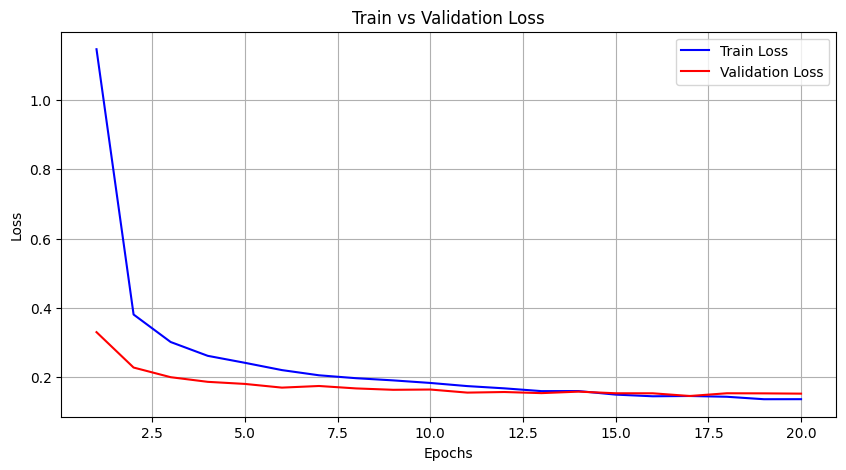

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label="Train Loss", color='blue')
plt.plot(epochs, val_loss, label="Validation Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


Train Accuracy vs Validation Accuracy

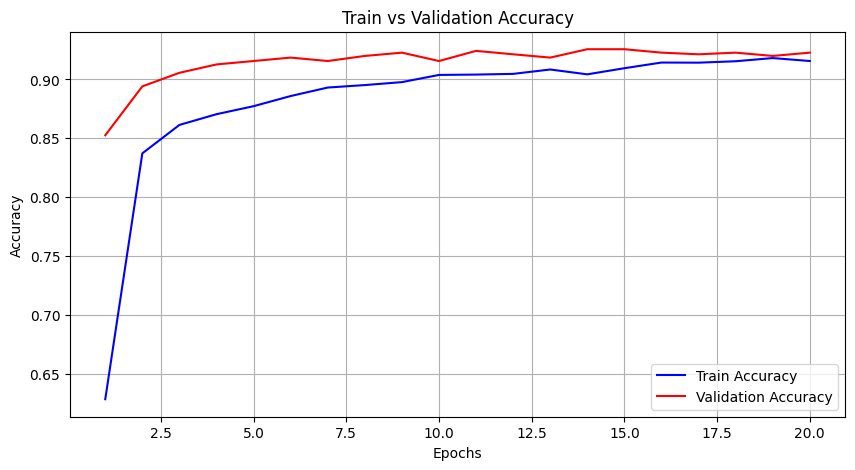

In [30]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, label="Train Accuracy", color='blue')
plt.plot(epochs, val_accuracy, label="Validation Accuracy", color='red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()


**Export to Tensorflow Lite Model**

After creating the model, convert and export it to a Tensorflow Lite model format for later use on an on-device application. The export also includes model metadata, which includes the label file.

In [16]:
model.export_model()

Using existing files at /tmp/model_maker/gesture_recognizer/gesture_embedder.tflite
Using existing files at /tmp/model_maker/gesture_recognizer/palm_detection_full.tflite
Using existing files at /tmp/model_maker/gesture_recognizer/hand_landmark_full.tflite
Using existing files at /tmp/model_maker/gesture_recognizer/canned_gesture_classifier.tflite


In [18]:
files.download('exported_model_Arsl/gesture_recognizer.task')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Hyperparameters {:#hyperparameters}


You can further customize the model using the `GestureRecognizerOptions` class, which has two optional parameters for `ModelOptions` and `HParams`. Use the `ModelOptions` class to customize parameters related to the model itself, and the `HParams` class to customize other parameters related to training and saving the model.

`ModelOptions` has one customizable parameter that affects accuracy:
* `dropout_rate`: The fraction of the input units to drop. Used in dropout layer. Defaults to 0.05.
* `layer_widths`: A list of hidden layer widths for the gesture model. Each element in the list will create a new hidden layer with the specified width. The hidden layers are separated with BatchNorm, Dropout, and ReLU. Defaults to an empty list(no hidden layers).

`HParams` has the following list of customizable parameters which affect model accuracy:
* `learning_rate`: The learning rate to use for gradient descent training. Defaults to 0.001.
* `batch_size`: Batch size for training. Defaults to 2.
* `epochs`: Number of training iterations over the dataset. Defaults to 10.
* `steps_per_epoch`: An optional integer that indicates the number of training steps per epoch. If not set, the training pipeline calculates the default steps per epoch as the training dataset size divided by batch size.
* `shuffle`: True if the dataset is shuffled before training. Defaults to False.
* `lr_decay`: Learning rate decay to use for gradient descent training. Defaults to 0.99.
* `gamma`: Gamma parameter for focal loss. Defaults to 2

Additional `HParams` parameter that does not affect model accuracy:
* `export_dir`: The location of the model checkpoint files and exported model files.